# Solution and simulation

In [4]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

import numpy as np
from matplotlib import pyplot as plt
import pickle
import seaborn as sns

from project_code.model import Model
from project_code.Simulation import simulate
import project_code.Estimation as est
import project_code.auxiliary_funcs as af
from project_code import auxiliary_funcs as af

import warnings
warnings.filterwarnings('ignore') #:)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Model setup and solution

In [5]:
model = Model()
model.setup()

# solution and simulation specs
model.par.Na = 200
model.par.Tmax = 45
model.par.Tsim = model.par.Tmax
model.par.Ntypes = 4
model.par.N = 10000

# parameter set 2
# High edu among rich, low among poor. Slightly higher edu among smart than poor
# rich matters more than smart
par2 = {'a_max':100,
        'Smax': 6,
        'sigma_taste': 0.3,
        'sigma': 0.5,
        'm_initial': 1,
        'phi_high': 5,
        'phi_low': 1,
        'theta_high':0.66,
        'theta_low':0.33,
        'lambda_max':0.797
        }

# set parameters
for key, val in par2.items():
    model.par.__setattr__(key, val)


model.set_grids()
par = model.par
sol = model.sol
sim = model.sim

In [6]:
model.solve()
print('solved')

solved


In [7]:
est.reset_sim(sim, model)
simulate(sim, sol, par)
print('simulated')

simulated


## Evaluate performance

In [8]:
#%lprun -T lprun_solve -f model.solve model.solve()

In [9]:
#%lprun -T lp_EGM -f EGM.EGM_step EGM.EGM_step(10, 0, 0, model)

# Plots of policy functions

### Example plot

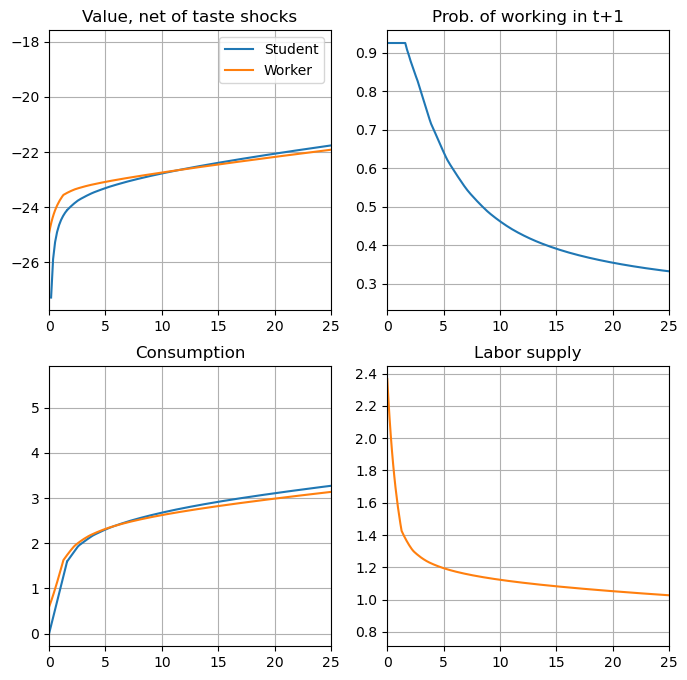

In [10]:
%matplotlib inline
t = 1
s = 1
type = 3

fig,ax = plt.subplots(2,2,figsize=(8,8))

mmax = 25

# value 
ax[0,0].plot(sol.m[type,t,0,s,1:,0],sol.V[type,t,0,s,1:,0],label = "Student", color='C0')
ax[0,0].plot(sol.m[type,t,1,s,1:,0],sol.V[type,t,1,s,1:,0],label = "Worker",color='C1')
ax[0,0].legend()
ax[0,0].set_title('Value, net of taste shocks')
ax[0,0].set_xlim(0,mmax)
ax[0,0].grid()

# ccp t+1
ax[0,1].plot(sol.m[type,t,0,s,:,0],sol.ccp_work[type,t,0,s,:,0],label = "Student", color='C0')
ax[0,1].set_title('Prob. of working in t+1')
ax[0,1].set_xlim(0,mmax)
ax[0,1].grid()

# consumption
ax[1,0].plot(sol.m[type,t,0,s,:,0],sol.c[type,t,0,s,:,0],label = "Student", color='C0')
ax[1,0].plot(sol.m[type,t,1,s,:,0],sol.c[type,t,1,s,:,0],label = "Working", color='C1')
ax[1,0].set_title('Consumption')
ax[1,0].set_xlim(0,mmax)
ax[1,0].grid()

# labor
ax[1,1].plot(sol.m[type,t,1,s,:,0],sol.ell[type,t,1,s,:,0],label = "Worker", color='C1')
ax[1,1].set_title('Labor supply')
ax[1,1].set_xlim(0,mmax)
ax[1,1].grid()

fig.savefig('figs/policy_func_example.png')

# Solution plots

### Wage function

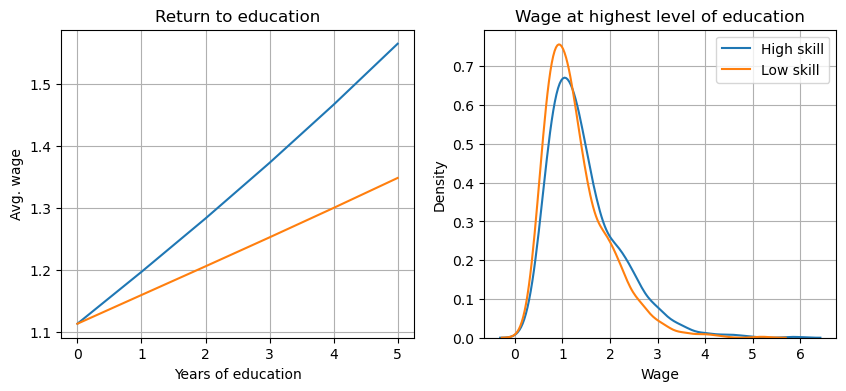

In [11]:
def wage(type, edu, eps, par):
    return np.exp(par.lambda_vec[edu]*np.log(1+par.theta[type]) + eps)

eps = np.random.normal(0, scale=par.sigma, size=1000)
wage_high = []
wage_low = []
for n in range(par.Smax):
    wage_high.append((af.wage_func(n, 0, 1, eps, par)).mean())
    wage_low.append((af.wage_func(n, 0, 3, eps, par)).mean())

from scipy.stats import gaussian_kde
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(wage_high, label='Smart')
ax1.plot(wage_low, label='Stupid')
ax1.set_ylabel("Avg. wage")
ax1.set_xlabel("Years of education")
ax1.set_title("Return to education")
ax1.grid(True)


wage0 = wage(0, 4, eps, par)
wage3 = wage(3, 4, eps, par)
ax2 = fig.add_subplot(1,2,2)
sns.kdeplot(wage0, ax=ax2, label='High skill')
sns.kdeplot(wage3, ax=ax2, label='Low skill')
ax2.set_xlabel("Wage")
ax2.legend()
ax2.set_title("Wage at highest level of education")
ax2.grid(True)

fig.savefig('figs/wage_return.png')

### Consumption in period t=0

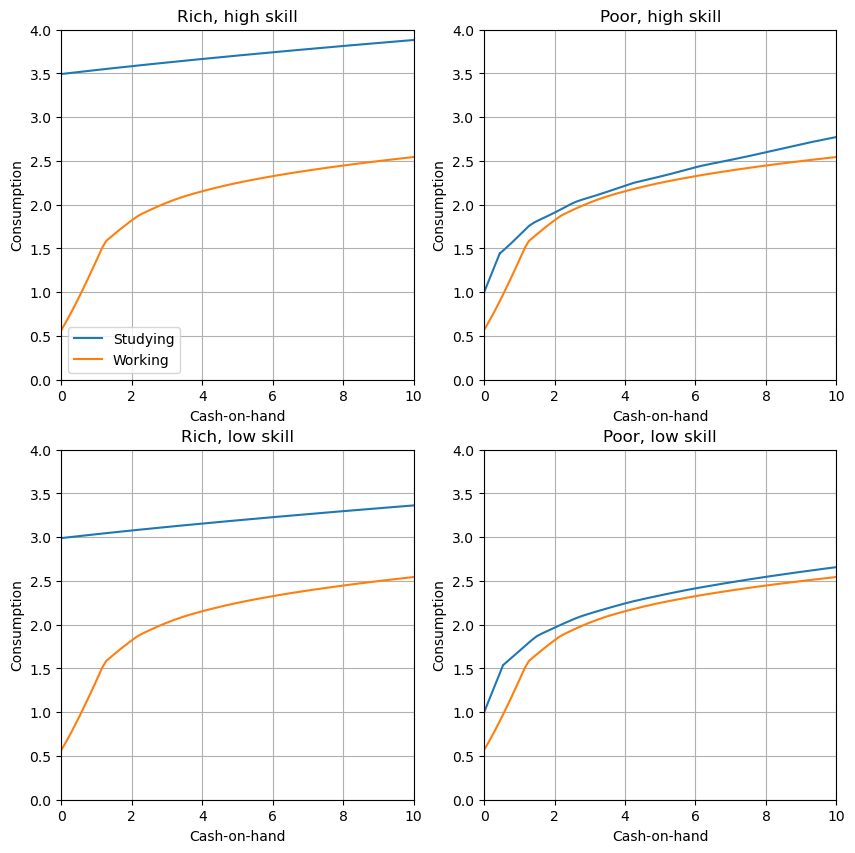

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))

time = 0
min_a = 0
max_a = 10

min_c = 0
max_c = 4

def plot_c_type(type, time, title, ax, legend=False):
    ax.plot(sol.m[type,time,0,time,:,0] - par.phi[type], sol.c[type,time,0,time,:,0], label="Studying")
    ax.plot(sol.m[type,time,1,time,:,0], sol.c[type,time,1,time,:,0], label="Working")
    ax.set_title(title)
    ax.set_xlim(min_a, max_a)
    ax.set_ylim(min_c, max_c)
    ax.grid()
    ax.set_xlabel("Cash-on-hand")
    ax.set_ylabel("Consumption")
    if legend:
        ax.legend()

ax0 = fig.add_subplot(2,2,1)
plot_c_type(0, time, "Rich, high skill", ax0, legend=True)

ax1 = fig.add_subplot(2,2,2)
plot_c_type(1, time, "Poor, high skill", ax1)

ax2 = fig.add_subplot(2,2,3)
plot_c_type(2, time, "Rich, low skill", ax2)

ax3 = fig.add_subplot(2,2,4)
plot_c_type(3, time, "Poor, low skill", ax3)

fig.savefig('figs/c_policy_2x2.png')

### Value in period t=0

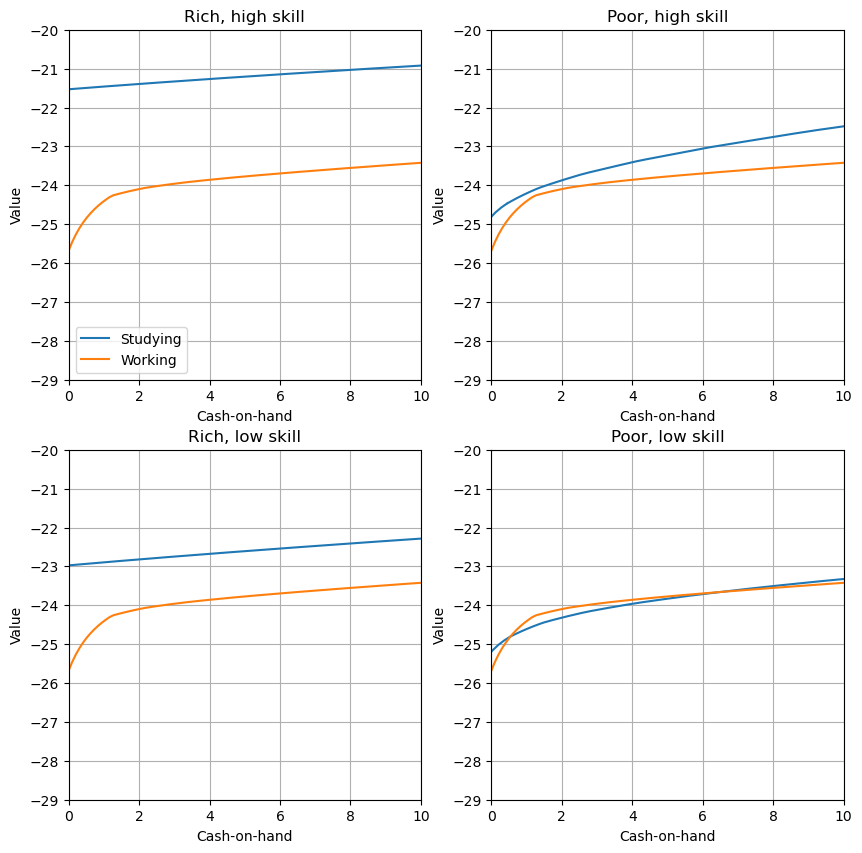

In [13]:
fig = plt.figure(figsize=(10,10))

max_a = 10
min_a = 0

max_v = -20
min_v = -29

time = 0

def plot_v_type(type, time, title, ax, legend=False):
    ax.plot(sol.m[type,time,0,time,2:,0] - par.phi[type], sol.V[type,time,0,time,2:,0], label="Studying")
    ax.plot(sol.m[type,time,1,time,:,0], sol.V[type,time,1,time,:,0], label="Working")
    ax.set_title(title)
    ax.set_xlim(min_a, max_a)
    ax.set_ylim(min_v, max_v)
    ax.grid()
    ax.set_xlabel("Cash-on-hand")
    ax.set_ylabel("Value")
    if legend:
        ax.legend()

ax0 = fig.add_subplot(2,2,1)
plot_v_type(0, time, "Rich, high skill", ax0, legend=True)

ax1 = fig.add_subplot(2,2,2)
plot_v_type(1, time, "Poor, high skill", ax1)

ax2 = fig.add_subplot(2,2,3)
plot_v_type(2, time, "Rich, low skill", ax2)

ax3 = fig.add_subplot(2,2,4)
plot_v_type(3, time, "Poor, low skill", ax3)

fig.savefig('figs/value_2x2.png')

## Conditional on studying

### Probability of working at time t+1

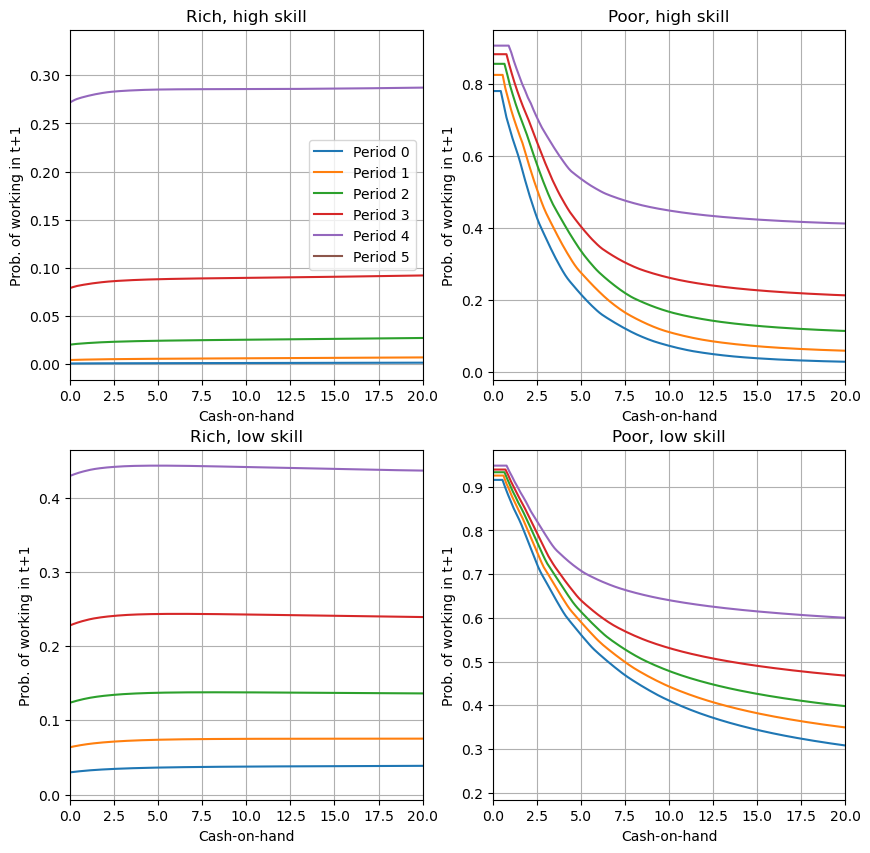

In [14]:
def plot_ccp_type(type, time, title, ax, legend=False):
    ax.plot(sol.m[type,time,0,time,2:,0] - par.phi[type], sol.ccp_work[type,time,0,time,2:,0], label=title)
    ax.set_xlim(min_a, max_a)
    ax.grid(True)
    ax.set_xlabel("Cash-on-hand")
    ax.set_ylabel("Prob. of working in t+1")
    if legend:
        ax.legend()

fig = plt.figure(figsize=(10,10))
max_a = 20
min_a = 0

ax0 = fig.add_subplot(2,2,1)
plot_ccp_type(0, 0, "Period 0", ax0, legend=True)
plot_ccp_type(0, 1, "Period 1", ax0, legend=True)
plot_ccp_type(0, 2, "Period 2", ax0, legend=True)
plot_ccp_type(0, 3, "Period 3", ax0, legend=True)
plot_ccp_type(0, 4, "Period 4", ax0, legend=True)
plot_ccp_type(0, 5, "Period 5", ax0, legend=True)
ax0.set_title('Rich, high skill')

ax1 = fig.add_subplot(2,2,2)
plot_ccp_type(1, 0, "Period 0", ax1)
plot_ccp_type(1, 1, "Period 1", ax1)
plot_ccp_type(1, 2, "Period 2", ax1)
plot_ccp_type(1, 3, "Period 3", ax1)
plot_ccp_type(1, 4, "Period 4", ax1)
plot_ccp_type(1, 5, "Period 5", ax1)
ax1.set_title('Poor, high skill')

ax2 = fig.add_subplot(2,2,3)
plot_ccp_type(2, 0, "Period 0", ax2)
plot_ccp_type(2, 1, "Period 1", ax2)
plot_ccp_type(2, 2, "Period 2", ax2)
plot_ccp_type(2, 3, "Period 3", ax2)
plot_ccp_type(2, 4, "Period 4", ax2)
plot_ccp_type(2, 5, "Period 5", ax2)
ax2.set_title('Rich, low skill')

ax3 = fig.add_subplot(2,2,4)
plot_ccp_type(3, 0, "Period 0", ax3)
plot_ccp_type(3, 1, "Period 1", ax3)
plot_ccp_type(3, 2, "Period 2", ax3)
plot_ccp_type(3, 3, "Period 3", ax3)
plot_ccp_type(3, 4, "Period 4", ax3)
plot_ccp_type(3, 5, "Period 5", ax3)
ax3.set_title('Poor, low skill')

fig.savefig('figs/ccp_2x2.png')

### Consumption

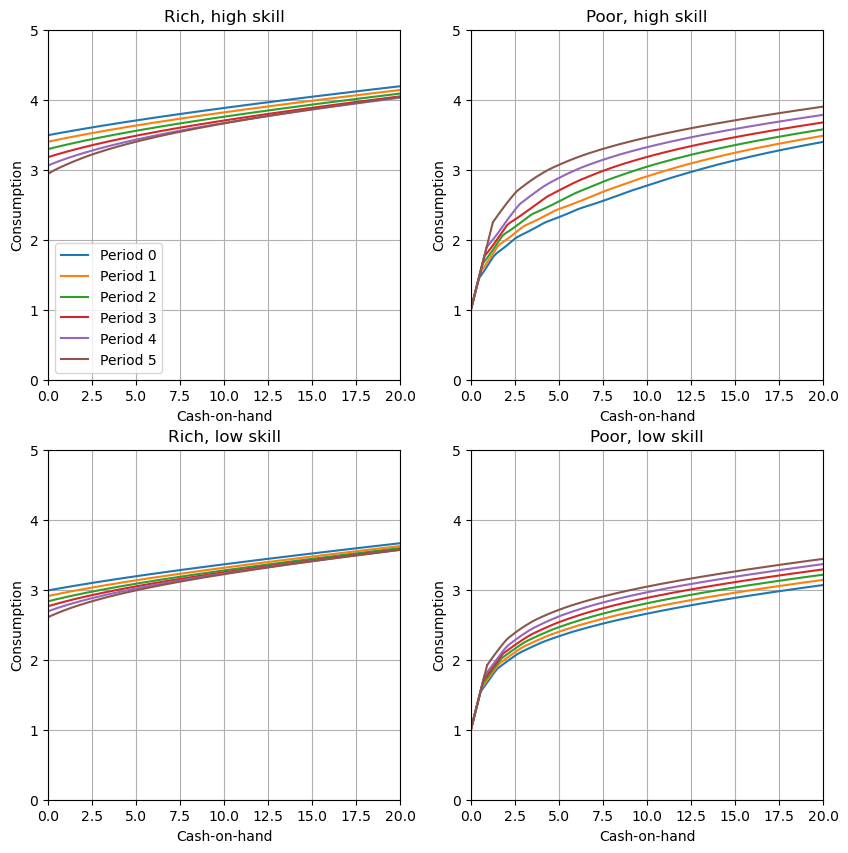

In [15]:
fig = plt.figure(figsize=(10,10))

max_a = 20
min_a = 0

min_c = 0
max_c = 5

def plot_c_type2(type, time, label, ax, legend=False):
    ax.plot(sol.m[type,time,0,time,:,0] - par.phi[type], sol.c[type,time,0,time,:,0], label=label)
    ax.set_xlim(min_a, max_a)
    ax.set_ylim(min_c, max_c)
    ax.grid()
    ax.set_xlabel("Cash-on-hand")
    ax.set_ylabel("Consumption")
    ax.grid(True)
    if legend:
        ax.legend()

ax0 = fig.add_subplot(2,2,1)
plot_c_type2(0, 0, "Period 0", ax0, legend=True)
plot_c_type2(0, 1, "Period 1", ax0, legend=True)
plot_c_type2(0, 2, "Period 2", ax0, legend=True)
plot_c_type2(0, 3, "Period 3", ax0, legend=True)
plot_c_type2(0, 4, "Period 4", ax0, legend=True)
plot_c_type2(0, 5, "Period 5", ax0, legend=True)
ax0.set_title('Rich, high skill')

ax1 = fig.add_subplot(2,2,2)
plot_c_type2(1, 0, "Period 0", ax1)
plot_c_type2(1, 1, "Period 1", ax1)
plot_c_type2(1, 2, "Period 2", ax1)
plot_c_type2(1, 3, "Period 3", ax1)
plot_c_type2(1, 4, "Period 4", ax1)
plot_c_type2(1, 5, "Period 5", ax1)
ax1.set_title('Poor, high skill')

ax2 = fig.add_subplot(2,2,3)
plot_c_type2(2, 0, "Period 0", ax2)
plot_c_type2(2, 1, "Period 1", ax2)
plot_c_type2(2, 2, "Period 2", ax2)
plot_c_type2(2, 3, "Period 3", ax2)
plot_c_type2(2, 4, "Period 4", ax2)
plot_c_type2(2, 5, "Period 5", ax2)
ax2.set_title('Rich, low skill')


ax3 = fig.add_subplot(2,2,4)
plot_c_type2(3, 0, "Period 0", ax3)
plot_c_type2(3, 1, "Period 1", ax3)
plot_c_type2(3, 2, "Period 2", ax3)
plot_c_type2(3, 3, "Period 3", ax3)
plot_c_type2(3, 4, "Period 4", ax3)
plot_c_type2(3, 5, "Period 5", ax3)
ax3.set_title('Poor, low skill')

fig.savefig('figs/c_study_2x2.png')

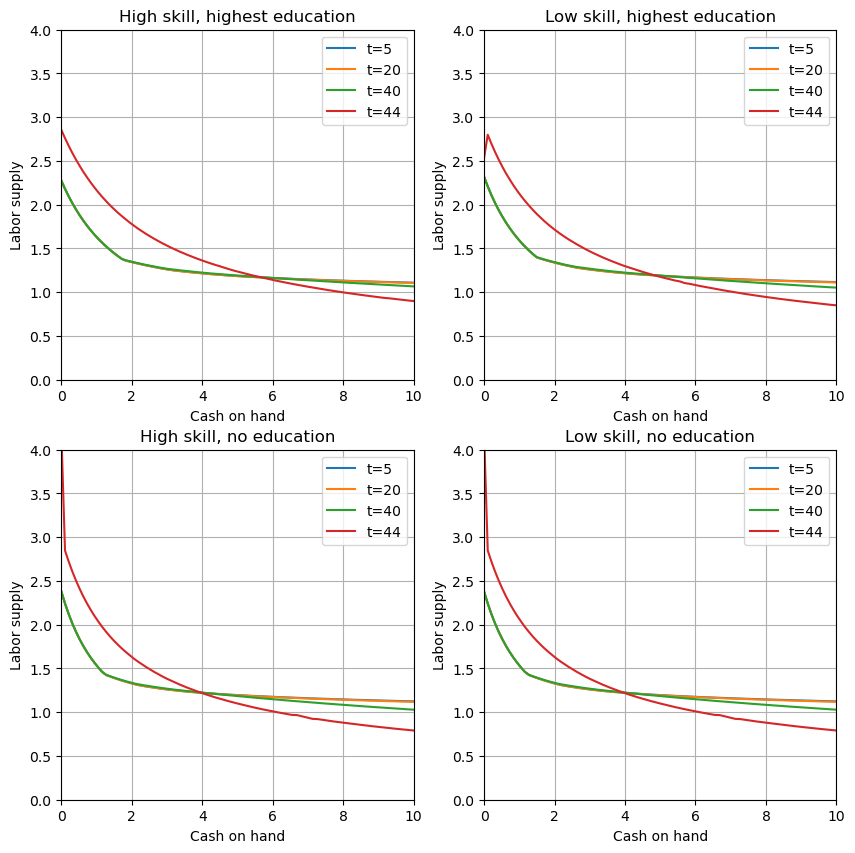

In [16]:
def plot_ell_work(type, times, edu, ax, legend=False):
    for time in times:
        ax.plot(sol.m[type,time,1,edu,par.Ba:,0], sol.ell[type,time,1,edu,par.Ba:,0], label=f't={time}')

    ax.set_xlabel("Cash on hand")
    ax.set_ylabel("Labor supply")
    ax.legend()
    ax.set_xlim(min_m, max_m)
    ax.set_ylim(min_l, max_l)
    ax.grid(True)

max_m = 10
min_m = 0
max_l = 4
min_l = 0
times = [5, 20, 40, 44]

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(2,2,1)
plot_ell_work(0, times, -1, ax0)
ax0.set_title('High skill, highest education')

ax1 = fig.add_subplot(2,2,2)
plot_ell_work(3,  times, -1, ax1)
ax1.set_title('Low skill, highest education')

ax2 = fig.add_subplot(2,2,3)
plot_ell_work(0, times, 0, ax2)
ax2.set_title('High skill, no education')

ax3 = fig.add_subplot(2,2,4)
plot_ell_work(3, times, 0, ax3)
ax3.set_title('Low skill, no education')

fig.savefig('figs/labor_2x2.png')


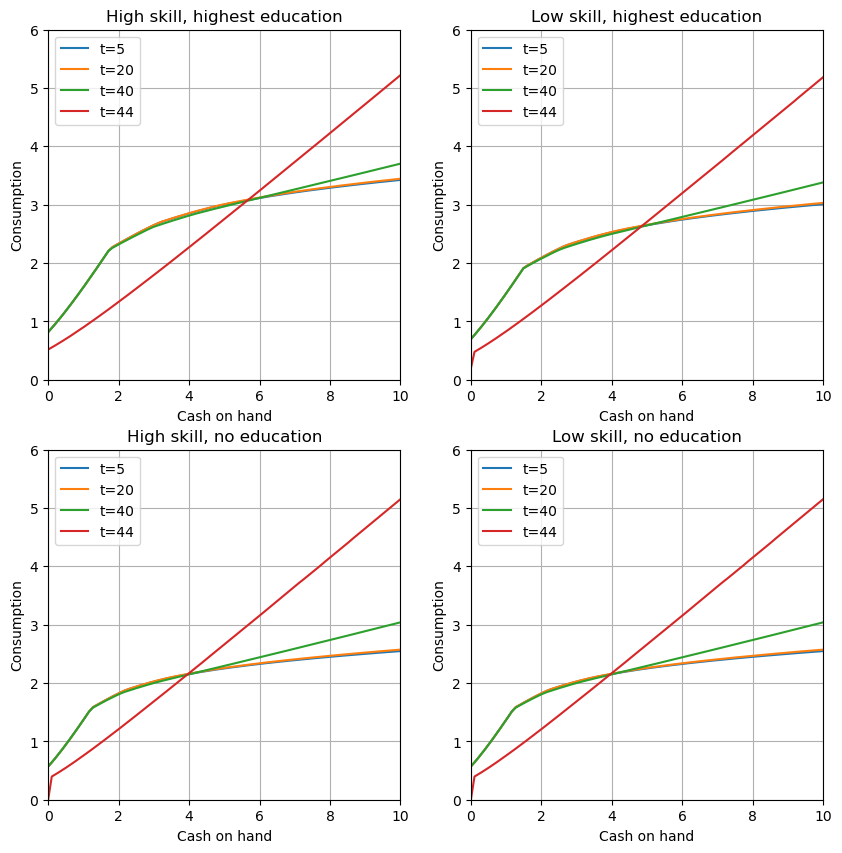

In [17]:
def plot_c_work(type, times, edu, ax, legend=False):
    for time in times:
        ax.plot(sol.m[type,time,1,edu,par.Ba:,0], sol.c[type,time,1,edu,par.Ba:,0], label=f't={time}')

    ax.set_xlabel("Cash on hand")
    ax.set_ylabel("Consumption")
    ax.legend()
    ax.set_xlim(min_m, max_m)
    ax.set_ylim(min_c, max_c)
    ax.grid(True)

max_m = 10
min_m = 0
max_c = 6
min_c = 0
times = [5, 20, 40, 44]

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(2,2,1)
plot_c_work(0, times, -1, ax0)
ax0.set_title('High skill, highest education')

ax1 = fig.add_subplot(2,2,2)
plot_c_work(3,  times, -1, ax1)
ax1.set_title('Low skill, highest education')

ax2 = fig.add_subplot(2,2,3)
plot_c_work(0, times, 0, ax2)
ax2.set_title('High skill, no education')

ax3 = fig.add_subplot(2,2,4)
plot_c_work(3, times, 0, ax3)
ax3.set_title('Low skill, no education')

fig.savefig('figs/c_work_2x2.png')

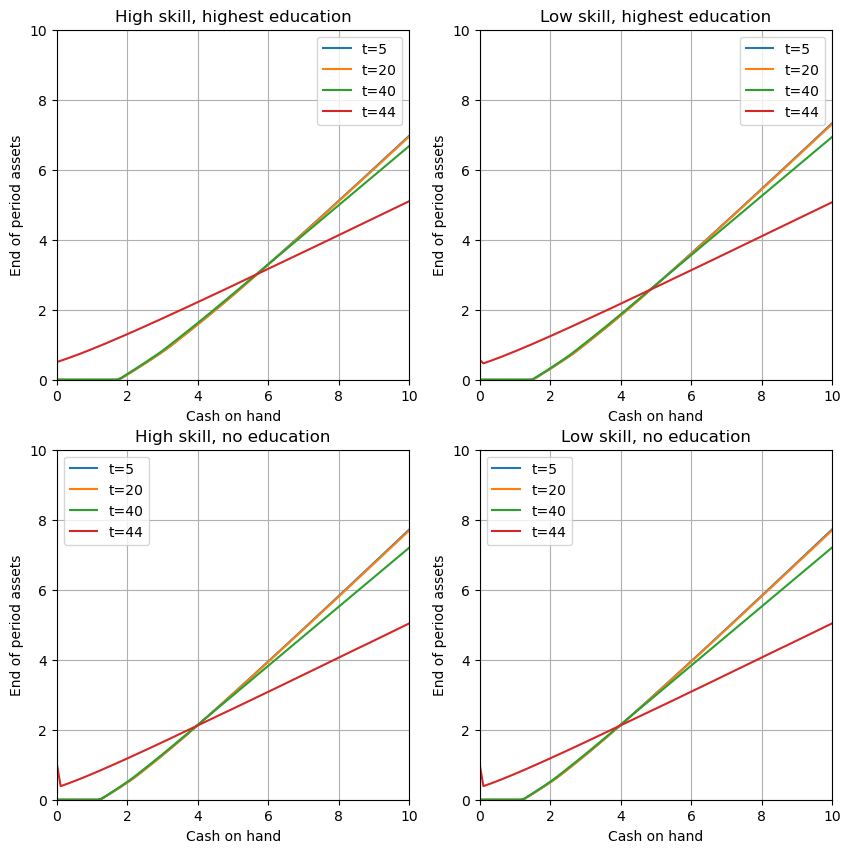

In [18]:
def plot_a_work(type, times, edu, ax, legend=False):
    for time in times:
        ax.plot(sol.m[type,time,1,edu,par.Ba:,0], sol.a[type,time,1,edu,par.Ba:,0], label=f't={time}')

    ax.set_xlabel("Cash on hand")
    ax.set_ylabel("End of period assets")
    ax.legend()
    ax.set_xlim(min_m, max_m)
    ax.set_ylim(min_a, max_a)
    ax.grid(True)

max_m = 10
min_m = 0
max_a = 10
min_a = 0
times = [5, 20, 40, 44]

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(2,2,1)
plot_a_work(0, times, -1, ax0)
ax0.set_title('High skill, highest education')

ax1 = fig.add_subplot(2,2,2)
plot_a_work(3,  times, -1, ax1)
ax1.set_title('Low skill, highest education')

ax2 = fig.add_subplot(2,2,3)
plot_a_work(0, times, 0, ax2)
ax2.set_title('High skill, no education')

ax3 = fig.add_subplot(2,2,4)
plot_a_work(3, times, 0, ax3)
ax3.set_title('Low skill, no education')

fig.savefig('figs/a_work_2x2.png')

## Simulation plots

### Life cycle profiles

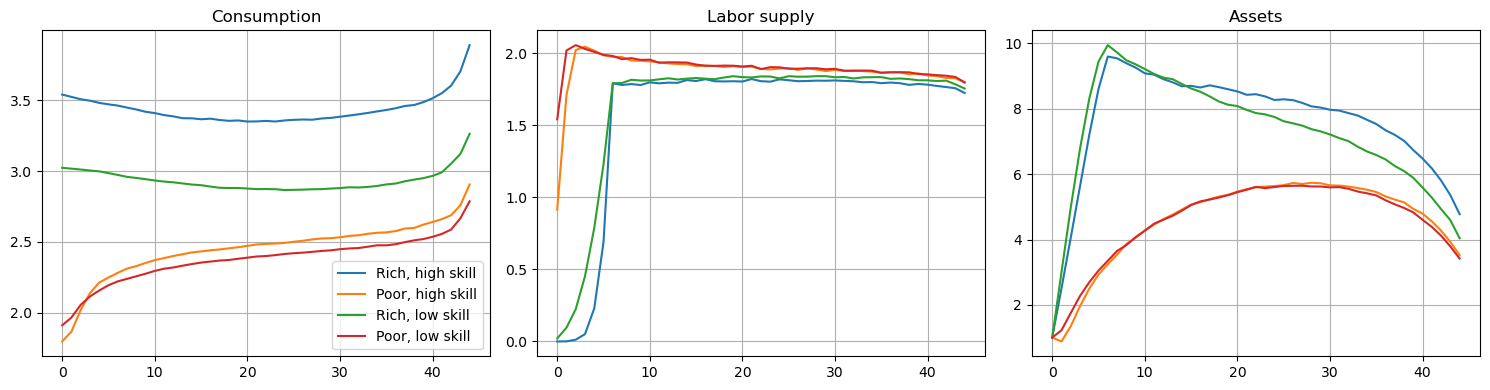

In [19]:
t0 = sim.type == 0
t1 = sim.type == 1
t2 = sim.type == 2
t3 = sim.type == 3

fig = plt.figure(figsize=(15,4))

ax0 = fig.add_subplot(1,3,1)
ax0.plot(sim.c[t0].mean(axis=0), label='Rich, high skill')
ax0.plot(sim.c[t1].mean(axis=0), label='Poor, high skill')
ax0.plot(sim.c[t2].mean(axis=0), label='Rich, low skill')
ax0.plot(sim.c[t3].mean(axis=0), label='Poor, low skill')
ax0.legend()
ax0.set_title('Consumption')
ax0.grid(True)

ax1 = fig.add_subplot(1,3,2)
ax1.plot(sim.ell[t0].mean(axis=0))
ax1.plot(sim.ell[t1].mean(axis=0))
ax1.plot(sim.ell[t2].mean(axis=0))
ax1.plot(sim.ell[t3].mean(axis=0))
ax1.set_title('Labor supply')
ax1.grid(True)

ax2 = fig.add_subplot(1,3,3)
ax2.plot(sim.m[t0].mean(axis=0))
ax2.plot(sim.m[t1].mean(axis=0))
ax2.plot(sim.m[t2].mean(axis=0))
ax2.plot(sim.m[t3].mean(axis=0))
ax2.set_title('Assets')
ax2.grid(True)

fig.tight_layout()
fig.savefig('figs/sim_life.png')

### Education distribution

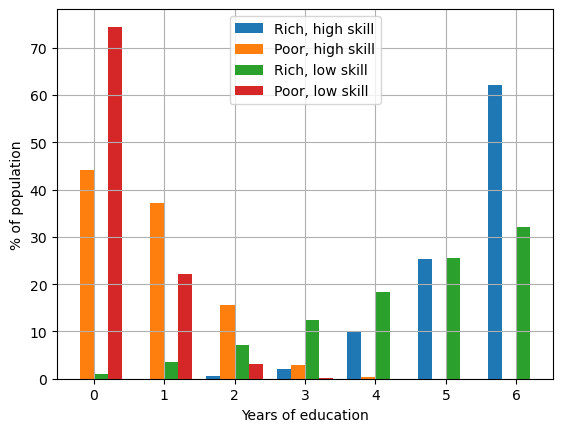

In [20]:
t0 =sim.type == 0
t1 = sim.type == 1
t2 = sim.type == 2
t3 = sim.type == 3

s = sim.S.max(axis=1)

t0_vec = np.unique(s[t0], return_counts=True)
t1_vec = np.unique(s[t1], return_counts=True)
t2_vec = np.unique(s[t2], return_counts=True)
t3_vec = np.unique(s[t3], return_counts=True)

width = 0.2
offset = [-0.3, -0.1, 0.1, 0.3]
vecs = [t0_vec, t1_vec, t2_vec, t3_vec]
labels = ['Rich, high skill', 'Poor, high skill', 'Rich, low skill', 'Poor, low skill']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i,vec in enumerate(vecs):
    denom = (vec[1]/vec[1].sum())*100
    ax.bar(vec[0] + offset[i], denom, width=width, label=labels[i])

ax.set_xlabel('Years of education')
ax.set_ylabel('% of population')
ax.legend()
ax.grid()

fig.savefig('figs/education.png')

## Evaluate performance: Euler and MRS errors

In [21]:
Delta_time_c, epsilon_time_c, Delta_time_ell, epsilon_time_ell, epsilon_MRS =  model.euler_errors()  

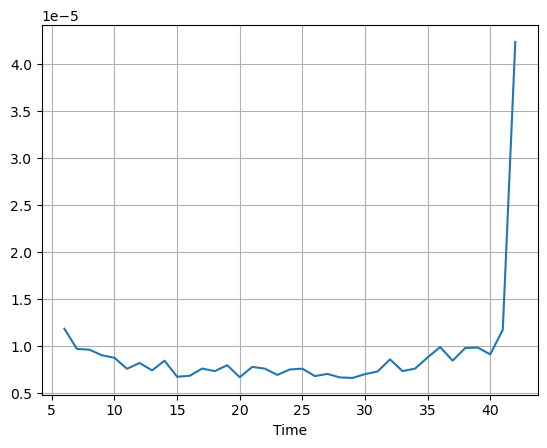

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(6,43), epsilon_MRS[:,6:-1].mean(axis=0))
#ax.set_title("Avg. MRS error")
ax.grid()
ax.set_xlabel('Time')
fig.savefig('figs/MRS_error.png')

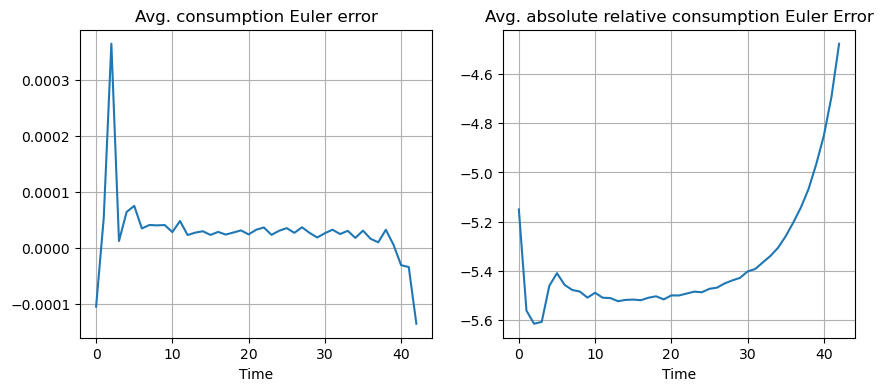

In [23]:
fig =plt.figure(figsize = (10,4))

ax = fig.add_subplot(1,2,1)
ax.plot(Delta_time_c[:-1])
ax.set_title('Avg. consumption Euler error')
ax.grid()
#ax.set_ylim(-.001,.001)
ax.set_xlabel('Time')

ax = fig.add_subplot(1,2,2)
ax.plot(np.array(epsilon_time_c[:-1]))
ax.set_title('Avg. absolute relative consumption Euler Error')
ax.grid()
ax.set_xlabel('Time')

fig.savefig('figs/cons_euler_error.png')


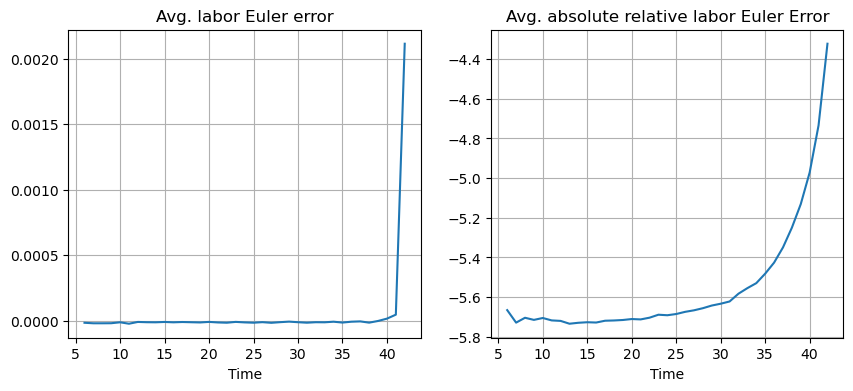

In [24]:
fig =plt.figure(figsize = (10,4))

ax = fig.add_subplot(1,2,1)
ax.plot(Delta_time_ell[:-1])
ax.set_title('Avg. labor Euler error')
ax.grid()
#ax.set_ylim(-.0001,.0001)
ax.set_xlabel('Time')

ax = fig.add_subplot(1,2,2)
ax.plot(np.array(epsilon_time_ell[:-1]))
ax.set_title('Avg. absolute relative labor Euler Error')
ax.grid()
ax.set_xlabel('Time')

fig.savefig('figs/lab_euler_error.png')